In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, models
from tensorflow.keras.layers import SpatialDropout2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, multiply, add
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import plot_model
from pyswarm import pso

In [2]:
base_path = r'C:\Users\KOJOGAH\Desktop\school\FINAL YEAR PROJECT\FYPDS7'
normal_path = os.path.join(base_path, 'Normal')
tumor_paths = [
    os.path.join(base_path, 'Tumor', 'glioma_tumor'),
    os.path.join(base_path, 'Tumor', 'meningioma_tumor'),
    os.path.join(base_path, 'Tumor', 'pituitary_tumor')
]

In [3]:
def normalize_image(img):
    min_val = np.min(img)
    max_val = np.max(img)
    return (img - min_val) / (max_val - min_val)

In [4]:
def display_images(images, labels, class_labels):
    for img, label in zip(images, labels):
        plt.imshow(img)
        plt.title(f"Class: {class_labels[label]}")
        plt.axis('off')
        plt.show()

In [5]:
def imagearray(path, size, label, class_labels, max_images=None):
    img_arrays = []
    labels = []

    count = 0
    for entry in os.listdir(path):
        entry_path = os.path.join(path, entry)

        if os.path.isfile(entry_path):
            img_arr = cv2.imread(entry_path)

            if img_arr is not None:
                img_arr = cv2.resize(img_arr, size)
                img_arrays.append(img_arr)
                labels.append(label)
                count += 1

                if max_images is not None and count >= max_images:
                    break
            else:
                print(f"Error: Could not read image at {entry_path}")

    return img_arrays, labels

In [6]:
desired_size = (224, 224)

In [7]:
normal_images, normal_labels = imagearray(normal_path, desired_size, label=0, class_labels={0: 'Normal'})

In [8]:
tumor_images = []
tumor_labels = []

In [9]:
for tumor_path, label in zip(tumor_paths, range(1, len(tumor_paths) + 1)):
    tumor_type = os.path.basename(tumor_path)
    images, labels = imagearray(tumor_path, desired_size, label=label, class_labels={0: 'Normal', label: tumor_type})
    tumor_images.extend(images)
    tumor_labels.extend(labels)

In [10]:
all_images = normal_images + tumor_images
all_labels = normal_labels + tumor_labels

In [11]:
# Convert lists to NumPy arrays
x = np.array(all_images)
y = np.array(all_labels)

In [12]:
# Split the data into training, testing, and validation sets
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.33, random_state=42)

In [13]:
# Label encoding using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [14]:
# Print the shapes of the resulting sets
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of x_train: (15170, 224, 224, 3)
Shape of y_train: (15170,)
Shape of x_test: (4356, 224, 224, 3)
Shape of y_test: (4356,)
Shape of x_val: (2146, 224, 224, 3)
Shape of y_val: (2146,)


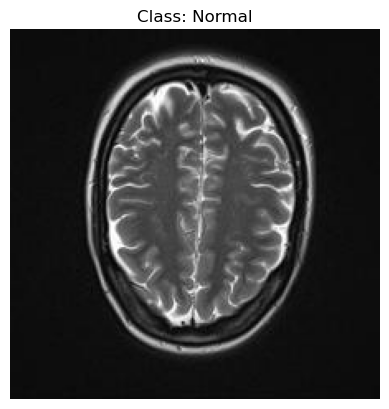

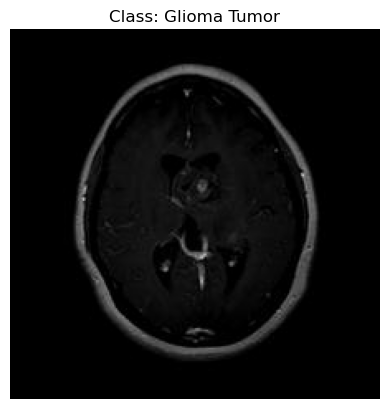

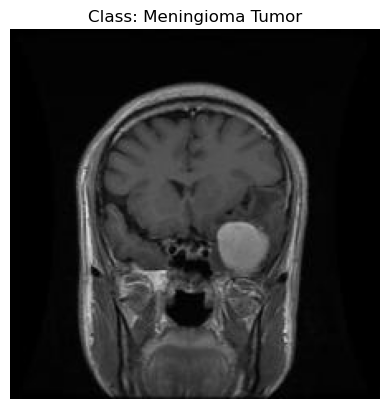

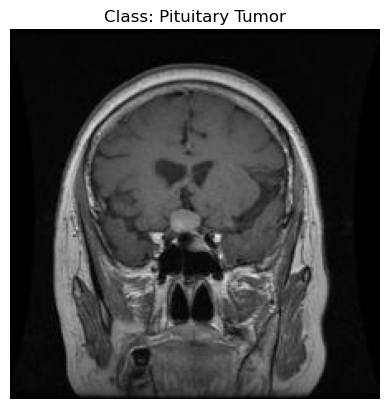

In [15]:
# Function for displaying images based on class
def display_images_by_class(images, labels, class_labels, num_per_class=1):
    unique_classes = np.unique(labels)
    images_to_display = []

    for class_label in unique_classes:
        class_indices = np.where(labels == class_label)[0]

        if class_indices.size > 0:
            # Display the first num_per_class images of the class
            images_to_display.extend(images[class_indices[:num_per_class]])

    # Display the images
    display_images(images_to_display, unique_classes, class_labels)

# Display sample images from each class
display_images_by_class(x_train, y_train, class_labels={0: 'Normal', 1: 'Glioma Tumor', 2: 'Meningioma Tumor', 3: 'Pituitary Tumor'})

In [16]:
def create_vgg19_model_with_dropout(input_shape, num_classes, dropout_rate):
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    x = vgg.output
    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)
    prediction = Dense(num_classes, activation="softmax")(x)
    model = Model(inputs=vgg.input, outputs=prediction)
    return model

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


NameError: name 'model' is not defined

In [ ]:
def model_fitness(dropout_rate):
    dropout_rate = np.clip(dropout_rate, 0.1, 0.5)
    model = create_vgg19_model_with_dropout(input_shape=(224, 224, 3), num_classes=len(label_encoder.classes_), dropout_rate=dropout_rate[0])
    history = model.fit(x_train, y_train_encoded, validation_data=(x_val, y_val_encoded), epochs=2, batch_size=32, shuffle=True, verbose=0)
    val_loss = history.history['val_loss'][-1]
    return val_loss

In [ ]:
bounds = [0.1, 0.5]
optimal_dropout_rate, fopt = pso(model_fitness, lb=[bounds[0]], ub=[bounds[1]], swarmsize=100, maxiter=10)

In [ ]:
print(f"Optimal dropout rate: {optimal_dropout_rate}, with validation loss: {fopt}")

In [ ]:
final_model = create_vgg19_model_with_dropout(input_shape=(224, 224, 3), num_classes=len(label_encoder.classes_), dropout_rate=optimal_dropout_rate)
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)
history = final_model.fit(x_train, y_train_encoded, validation_data=(x_val, y_val_encoded), epochs=2, callbacks=[early_stop], batch_size=32, shuffle=True)

In [ ]:
final_model.summary()

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.show

In [ ]:
# Evaluate the model on the test set
model.evaluate(x_test, label_encoder.transform(y_test), batch_size=32)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
# Print classification report and confusion matrix
print(classification_report(label_encoder.transform(y_test), y_pred))

In [ ]:
cm = confusion_matrix(label_encoder.transform(y_test), y_pred)

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
ax = plt.subplot()
sns.set(font_scale=2.0)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)  # Corrected syntax error
ax.xaxis.set_ticklabels(['Normal', 'Glioma', 'Meningioma', 'Pituitary'], fontsize=20)
ax.yaxis.set_ticklabels(['Normal', 'Glioma', 'Meningioma', 'Pituitary'], fontsize=20)

In [ ]:
# Calculate and print F1 score, recall, precision and accuracy
f1 = f1_score(label_encoder.transform(y_test), y_pred, average='micro')
recall = recall_score(label_encoder.transform(y_test), y_pred, average='weighted')
precision = precision_score(label_encoder.transform(y_test), y_pred, average='micro')
accuracy = accuracy_score(label_encoder.transform(y_test), y_pred)

In [ ]:
print("Final Model Metrics:")
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)
print("Accuracy:", accuracy)